In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy.io import mmread
import random
import math
#import scanpy as sc
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import gamma
from scipy.stats import poisson
from scipy.stats import multivariate_normal
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from scipy import special
import operator
from numpy import genfromtxt

In [2]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev) 

if torch.cuda.is_available():
   print ("Cuda is available")
   device_id = torch.cuda.current_device()
   gpu_properties = torch.cuda.get_device_properties(device_id)
   print("Found %d GPUs available. Using GPU %d (%s) of compute capability %d.%d with "
          "%.1fGb total memory.\n" % 
          (torch.cuda.device_count(),
          device_id,
          gpu_properties.name,
          gpu_properties.major,
          gpu_properties.minor,
          gpu_properties.total_memory / 1e9))
else:    
   print ("Cuda is not available")

Cuda is available
Found 1 GPUs available. Using GPU 0 (NVIDIA A100-PCIE-40GB) of compute capability 8.0 with 42.4Gb total memory.



In [3]:
def metrics(prediction, label, cut = 0.5):
    
    dichotomized = np.where(prediction > cut, 1, 0)
    sensitivity = np.sum(dichotomized[label==1]==1)/dichotomized[label==1].shape[0]
    specificity = np.sum(dichotomized[label==0]==0)/dichotomized[label==0].shape[0]
    precision = np.sum(dichotomized[label==1]==1)/np.sum(dichotomized==1)
    prop = np.sum(dichotomized==1)/label.shape[0]
    f1 = 2*precision*sensitivity/(precision+sensitivity)
    #print("Predicted doublet proportion:",prop)
    #print("Precision:", precision)
    #print("f1 score:", f1)
    
    return f1

In [4]:
#RNA

In [5]:
#intialization: theta is based on estimated doublet proportion; 
#               alpha and beta is estimated by assuming a simple gamma distribution and estimated by method of moment
def initialization_rna(theta, data):
  #theta is a numerical value
  #data should be the count matrix in tensor form
  theta = torch.tensor(theta, device = dev)
  mu = torch.mean(data, dim=0)
  var = torch.var(data, dim=0)
  alpha = torch.square(mu)/var.to(dev)
  beta = mu/var.to(dev)

  theta = theta.requires_grad_()
  alpha = alpha.requires_grad_()
  beta = beta.requires_grad_()
  #print(torch.mean(alpha))

  return theta, alpha, beta

#log likelihood
def loglik_rna(N, theta, alpha, beta, decay, data):
  #N is the user estimated maximum number of cells in a droplet
  #theta, alpha, and beta are outputs from initialization function
  #data should be the count matrix in tensor form
  
  poisson = torch.distributions.Poisson(theta)
  for k in range(N):
    gamma = torch.distributions.Gamma(alpha*(1+torch.tensor(k, device = dev)/(1+torch.exp(-decay))), beta)
    if k ==0 :
      sum_k = gamma.log_prob(data).exp()*poisson.log_prob(torch.tensor([k], device = dev)).exp()
    else:
      sum_k = sum_k.clone() + gamma.log_prob(data).exp()*poisson.log_prob(torch.tensor([k], device = dev)).exp() #sum of likelihood

  l = sum_k.log().sum()
  return l

def MLE_rna(data, N=3, p=0.7, lr=0.001, tolerance = 15):
   #p is a numerical value, initial guess of singlet rate; this value doesn't have a big impact on parameter estimation
   #data should be the count matrix in tensor form
   #N is the user estimated maximum number of cells in a droplet
   #tolerance controls how many steps we allow the loss not to improve

    x = data
    x.requires_grad_(False)  ## data

    decay = torch.tensor(0.0, device = dev)
    decay = decay.requires_grad_()

    theta = -math.log(p)
    theta, alpha, beta = initialization_rna(theta, data)
    alpha0 = 0.5*torch.mean(alpha).to('cpu').detach().item()
    parameters = [theta, alpha, beta, decay]


    # Defines a SGD optimizer to update the parameters
    #optimizer = optim.SGD(parameters, lr=learning_rate) # not working
    optimizer = optim.Adam(parameters, lr=lr)
    #optimizer = optim.Rprop(parameters, lr=learning_rate)
    NLL_0 = -loglik_rna(N, theta, alpha, beta, decay, x)
    l = []
    singlet_rate = []
    

    for i in range(5000):
        NLL = -loglik_rna(N, theta, alpha, beta, decay, x)
        if i % 200 == 0:
            l.append(NLL.to('cpu').detach())
            singlet_rate.append(torch.tensor([-theta]).exp())
            if len(l) > 2:
              if (l[-2] - l[-1]) < 0.01*(l[0] - l[1]):
                tolerance = tolerance - 1
        if tolerance == 0:
          break

        NLL.backward()
        optimizer.step()
        optimizer.zero_grad()
        theta.data.clamp_(0.001, 1.0)
        decay.data.clamp_(-10, 10)
        alpha.data.clamp_(min = alpha0)

    
    return theta, alpha, beta, decay, l, singlet_rate

def log_joint_one_k_rna(data, theta, alpha, beta, decay, k0):
  #k0 starts from 0, same interpretation as the k0 in the derivation
  alpha = alpha.to('cpu').detach().numpy()
  beta = beta.to('cpu').detach().numpy()
  data = data.to('cpu').numpy()
  theta = theta.to('cpu').detach().numpy()
  decay = decay.to('cpu').detach().numpy()

  alpha = alpha*(1+k0/(1+np.exp(-decay)))

  log_conditional = np.log(gamma.pdf(data, alpha, loc=0, scale=1/beta)) 
  sum_gene = np.sum(log_conditional, axis = 1)
  log_joint = sum_gene + np.log(poisson.pmf(k0, theta))
  var_by_cell = np.var(np.exp(log_conditional), axis = 1)

  return log_joint

def prob_k0_rna(data, theta, alpha, beta, decay, k0, k=3):
  log_joint_k0 = log_joint_one_k_rna(data, theta, alpha, beta, decay, k0)

  one_ks = np.ones((data.shape[0],k))
  for i in np.arange(k):
    one_ks[:,i] = log_joint_one_k_rna(data, theta, alpha, beta, decay, i)
  
  logsumexp_ks = special.logsumexp(one_ks, axis = 1)
  log_prob = log_joint_k0 - logsumexp_ks
  log_prob = log_prob.astype('float128')
  prob = np.exp(log_prob, dtype=np.float128)


  return prob

def reliability_rna(data, theta, alpha, beta, decay, k=3):
    
    
    prob_singlet = prob_k0_rna(data, theta, alpha, beta, decay, 0, k)
    prob_doublet = 1-prob_singlet
    pred = np.where(prob_doublet > 0.5, True, False)
    
    alpha = alpha.to('cpu').detach().numpy()
    beta = beta.to('cpu').detach().numpy()
    data = data.to('cpu').numpy()
    theta = theta.to('cpu').detach().numpy()
    decay = decay.to('cpu').detach().numpy()
      
    one_ks = np.ones((data.shape[0], data.shape[1], k))
    for i in np.arange(k):
        alpha_k = alpha*(1+i/(1+np.exp(-decay)))
        one_ks[:,:,i] = np.log(gamma.pdf(data,  alpha_k, loc=0, scale=1/beta))

        

    
    reliability = 1 - (np.exp(one_ks[:,:,0]-special.logsumexp(one_ks, axis = 2))) #probability of doublets predicted by individual feature
    
    
    #if individual feature prediction result is the same as result by all features, then record as 1. otherwise record as 0
    #then, calculate proportion of features that can individually provide correct prediction
    reliability[pred,:]=np.where(reliability[pred,:] > 0.5, 1, 0) #predicted doublets
    reliability[list(map(operator.not_, pred)),:]=np.where(reliability[list(map(operator.not_, pred)),:] < 0.5, 1, 0)

    reliability = np.sum(reliability, axis = 1)/data.shape[1]

    result = np.zeros((2, data.shape[0]))
    result[0,:] = reliability
    result[1,:] = np.where(reliability <= 0.5, 1, 0) #flags the cells whose prediction is subject to outliers
    

    return result

def rna_fit_goodness(data, alpha, beta, theta, decay, k=3):
    
    data = torch.round(data)
    data = data.int()
    data = data.to('cpu').numpy()
    alpha = alpha.to('cpu').detach().numpy()
    beta = beta.to('cpu').detach().numpy()
    theta = theta.to('cpu').detach().numpy()
    decay = decay.to('cpu').detach().numpy()
    
    empirical = np.apply_along_axis(lambda x: np.bincount(x, minlength=np.max(data)+1), axis=0, arr=data)
    empirical_dist = empirical/data.shape[0] 
    empirical_dist #each column is the empirical distribution of a gene

    for i in range(empirical_dist.shape[0]-1):
        empirical_dist[i+1,] += empirical_dist[i,] #empirical cdf
    
    #calculate theoretical cdf below
    grid = np.expand_dims(np.arange(0, empirical_dist.shape[0], 1, dtype=int)+0.0001,axis=1)
    grid=np.repeat(grid, empirical_dist.shape[1], axis = 1)
    
    one_ks = np.ones((grid.shape[0], grid.shape[1], k))

    for i in np.arange(k):
        alpha_k = alpha*(1+i/(1+np.exp(-decay)))
        one_ks[:,:,i] = np.log(gamma.cdf(grid, alpha_k, loc=0, scale=1/beta))+np.log(poisson.pmf(i, theta))

    logsumexp_ks = special.logsumexp(one_ks, axis = 2)    
    theoretical_dist = np.exp(logsumexp_ks)
    
    diff = np.abs(theoretical_dist-empirical_dist)
    mean_ks = np.mean(np.amax(diff, axis = 0))
    
    
    if mean_ks > 0.33:
        print("The RNA modality goodness-of-fit score is less than 3; The model may not fit the data well")
    
    return mean_ks

    
def composite_rna(stable, doublet_label, N=3, lr=0.001, p=0.7, stable_criterion = "signal", stable_number = None, tolerance = 10):
    
    #N: the maximum number of cells in a droplet that will be modeled
    #lr: learning rate in the maximum likelihood estimation step; Note that the recommanded learning rates for different modalities are different
    #p: user estimated singlet proportion
    #stable_criterion: By default, stable features are selected to have high signal-to-noise ratio.
    #                  User may set it to "mean" so that stable features are selected to have high mean expression level
    #stable_number: number of stable features to be selected for modeling
    #tolerance: Controls early stopping. Increasing this number may slightly improve model performance but will significantly increase computing time
    
    
    #rna_input = mmread(input_path)
    #stable = select_stable(rna_input, modality = "RNA", criterion = stable_criterion, stable_number = stable_number)
    #stable = torch.tensor(stable, device = dev)
    #stable = stable.double()
    #stable = stable + torch.tensor([0.0001], device = dev)
    theta,alpha,beta,decay, loss,p = MLE_rna(stable, N=N, p=p, lr=lr, tolerance=tolerance)
    rna_fit = rna_fit_goodness(stable, alpha, beta, theta, decay, k=N)
    prob_singlet = prob_k0_rna(stable, theta, alpha, beta, decay, 0, k=N)
    prob_doublet = 1-prob_singlet
    doublet_classification = np.where(prob_doublet > 0.5, 1, 0)
    reliability_table = reliability_rna(stable, theta, alpha, beta, decay, k=N)
    rna_overall_weight = reliability_table[0,]/rna_fit
    data = {#'prob_doublet': prob_doublet,
            'doublet_classification': doublet_classification,
            'consistency':reliability_table[0,]}

    # Create DataFrame
    reliability_file = pd.DataFrame(data)
    reliability_file.index.name = 'index'
    reliability_file.reset_index(inplace=True)
    #reliability_file.to_csv(output_path,index=False)
    
    #print("The RNA modality goodness-of-fit score is:", 1/rna_fit, "\n<3: poor fit \n3~5: moderate fit \n>5: good fit")
    f1 = metrics(prob_doublet, doublet_label, cut = 0.5)
    
    return f1



In [6]:
#ADT

In [7]:
#Initialization for multivariate gaussian parameters
#parameter alpha is the location parameter, and beta is the covariance matrix/std parameter
#the covariance parameter is estimated by the unbiased estimator

def initialization_adt(theta, data, corr):
    
  if corr == True:
      #theta is a numerical value
      #data should be the count matrix in tensor form
      theta = torch.tensor(theta, device = dev)
      alpha = torch.mean(data, dim=0)
      beta = torch.cov(torch.transpose(data,0,1))


      theta = theta.requires_grad_()
      alpha = alpha.requires_grad_()
      beta = beta.requires_grad_()

  else:
      #theta is a numerical value
      #data should be the count matrix in tensor form
      theta = torch.tensor(theta, device = dev)
      alpha = torch.mean(data, dim=0)
      var = torch.var(data, dim=0)
      beta = torch.sqrt(var)


      theta = theta.requires_grad_()
      alpha = alpha.requires_grad_()
      beta = beta.requires_grad_()
  
  
  return theta, alpha, beta



#log likelihood with logsumexp
def loglik_adt(N, theta, alpha, beta, decay, data, corr):

  if corr == True:
    
      #N is the user estimated maximum number of cells in a droplet
      #theta, alpha, and beta are outputs from initialization function
      #data should be the count matrix in tensor form
      poisson = torch.distributions.Poisson(theta)
      list_k = torch.zeros(N,data.shape[0])
      for k in range(N):
        gaussian = torch.distributions.MultivariateNormal(alpha*(1+torch.tensor(k, device = dev)/(1+torch.exp(-decay))), torch.tensor(k+1, device = dev)*beta)
        list_k[k] = gaussian.log_prob(data)+poisson.log_prob(torch.tensor([k], device = dev))

      sum_k = torch.logsumexp(list_k,0)
      l = torch.sum(sum_k, dtype = torch.float64)

    
  else: 
      #N is the user estimated maximum number of cells in a droplet
      #theta, alpha, and beta are outputs from initialization function
      #data should be the count matrix in tensor form
      poisson = torch.distributions.Poisson(theta)
      list_k = torch.zeros(N, data.shape[0], data.shape[1])
      for k in range(N):
        gaussian = torch.distributions.Normal(alpha*(1+torch.tensor(k, device = dev)/(1+torch.exp(-decay))), torch.tensor(k+1, device = dev)*beta)
        list_k[k] = gaussian.log_prob(data)+poisson.log_prob(torch.tensor([k], device = dev))

      sum_k = torch.logsumexp(list_k, 0)
      l = torch.sum(sum_k, dtype = torch.float64)


  return l

def MLE_adt(data, N=3, p=0.7, lr=0.02, tolerance = 15, corr = False):
   #p is a numerical value, initial guess of singlet rate; this value doesn't have a big impact on parameter estimation
   #data should be the count matrix in tensor form
   #N is the user estimated maximum number of cells in a droplet
   #tolerance controls how many steps we allow the loss not to improve

    x = data
    x.requires_grad_(False)  ## data

    decay = torch.tensor(0.0, device = dev)
    decay = decay.requires_grad_()

    theta = -math.log(p)
    theta, alpha, beta = initialization_adt(theta, data, corr)
    alpha0 = 0.5*torch.mean(alpha).to('cpu').detach().item()

    parameters = [theta, alpha, beta, decay]


    optimizer = optim.Adam(parameters, lr=lr, eps = 1e-6, weight_decay=0.1)

    l = []
    singlet_rate = []

    
    for i in range(10000):
        NLL = -loglik_adt(N, theta, alpha, beta, decay, x, corr)
        if i % 200 == 0:
            l.append(NLL.to('cpu').detach())
            singlet_rate.append(torch.tensor([-theta]).exp())
            if len(l) > 2:
              if (l[-2] - l[-1]) < 0.01*(l[0] - l[1]):
                tolerance = tolerance - 1
        if tolerance == 0:
          break

        NLL.backward()
        optimizer.step()
        optimizer.zero_grad()
        theta.data.clamp_(0.01, 1.0)
        decay.data.clamp_(-10, 10)
        alpha.data.clamp_(min = 0)
        beta.data.clamp_(min = 0)
        


    return theta, alpha, beta, decay, l, singlet_rate



def log_joint_one_k_adt(data, theta, alpha, beta, decay, k0, corr):
    
  if corr == True:
      #k0 starts from 0, same interpretation as the k0 in the derivation
      alpha = alpha.to('cpu').detach().numpy()
      beta = beta.to('cpu').detach().numpy()
      data = data.to('cpu').numpy()
      theta = theta.to('cpu').detach().numpy()
      decay = decay.to('cpu').detach().numpy()

      alpha = alpha*(1+k0/(1+np.exp(-decay)))

      log_conditional = np.log(multivariate_normal.pdf(data, mean=alpha, cov=beta)+1e-320) 
      log_joint = log_conditional + np.log(poisson.pmf(k0, theta))

    
  else:
      #k0 starts from 0, same interpretation as the k0 in the derivation
      alpha = alpha.to('cpu').detach().numpy()
      beta = beta.to('cpu').detach().numpy()
      data = data.to('cpu').numpy()
      theta = theta.to('cpu').detach().numpy()
      decay = decay.to('cpu').detach().numpy()

      alpha = alpha*(1+k0/(1+np.exp(-decay)))

      log_conditional = np.log(norm.pdf(data, loc=alpha, scale=beta)+1e-320) #add a small value to avoid log(0)
      sum_gene = np.sum(log_conditional, axis = 1)
      log_joint = sum_gene + np.log(poisson.pmf(k0, theta))
      var_by_cell = np.var(np.exp(log_conditional), axis = 1)

  return log_joint

def prob_k0_adt(data, theta, alpha, beta, decay, k0, k=3, corr = False):
  log_joint_k0 = log_joint_one_k_adt(data, theta, alpha, beta, decay, k0, corr)

  one_ks = np.ones((data.shape[0],k))
  for i in np.arange(k):
    one_ks[:,i] = log_joint_one_k_adt(data, theta, alpha, beta, decay, i, corr)
  
  logsumexp_ks = special.logsumexp(one_ks, axis = 1)
  log_prob = log_joint_k0 - logsumexp_ks
  log_prob = log_prob.astype('float128')
  prob = np.exp(log_prob, dtype=np.float128)
  


  return prob

def reliability_adt(data, theta, alpha, beta, decay, k=3,corr = False):
    
    if corr == True:
        beta = torch.diagonal(beta, 0)
        beta = torch.sqrt(beta)
    
        prob_singlet = prob_k0_adt(data, theta, alpha, beta, decay, 0, k, corr = True)
        prob_doublet = 1-prob_singlet
        pred = np.where(prob_doublet > 0.5, True, False)
        
    else:
        prob_singlet = prob_k0_adt(data, theta, alpha, beta, decay, 0, k)
        prob_doublet = 1-prob_singlet
        pred = np.where(prob_doublet > 0.5, True, False)
    
    alpha = alpha.to('cpu').detach().numpy()
    beta = beta.to('cpu').detach().numpy()
    data = data.to('cpu').numpy()
    theta = theta.to('cpu').detach().numpy()
    decay = decay.to('cpu').detach().numpy()
      
    one_ks = np.ones((data.shape[0], data.shape[1], k))
    for i in np.arange(k):
        alpha_k = alpha*(1+i/(1+np.exp(-decay)))
        one_ks[:,:,i] = np.log(norm.pdf(data, loc=alpha_k, scale=beta)+1e-320)

    reliability = 1 - (np.exp(one_ks[:,:,0]-special.logsumexp(one_ks, axis = 2))) #probability of doublets predicted by individual feature

    #if individual feature prediction result is the same as result by all features, then record as 1. otherwise record as 0
    #then, calculate proportion of features that can individually provide correct prediction
    reliability[pred,:]=np.where(reliability[pred,:] > 0.5, 1, 0) #predicted doublets
    reliability[list(map(operator.not_, pred)),:]=np.where(reliability[list(map(operator.not_, pred)),:] < 0.5, 1, 0)

    reliability = np.sum(reliability, axis = 1)/data.shape[1]

    result = np.zeros((2, data.shape[0]))
    result[0,:] = reliability
    result[1,:] = np.where(reliability <= 0.5, 1, 0) #flags the cells whose prediction is subject to outliers
    

    return result

def adt_fit_goodness(data, alpha, beta, theta, decay, k=3, corr=False):
    
    if corr == True:
        beta = torch.diagonal(beta, 0)
        beta = torch.sqrt(beta)
    
    data = torch.round(data)
    data = data.int()
    data = data.to('cpu').numpy()
    alpha = alpha.to('cpu').detach().numpy()
    beta = beta.to('cpu').detach().numpy()
    theta = theta.to('cpu').detach().numpy()
    decay = decay.to('cpu').detach().numpy()
    
    empirical = np.apply_along_axis(lambda x: np.bincount(x, minlength=np.max(data)+1), axis=0, arr=data)
    empirical_dist = empirical/data.shape[0] #+ 1e-100 #adjust 1e-100 as needed
    empirical_dist #each column is the empirical distribution of a gene

    for i in range(empirical_dist.shape[0]-1):
        empirical_dist[i+1,] += empirical_dist[i,] #empirical cdf
    
    #calculate theoretical cdf below
    grid = np.expand_dims(np.arange(0, empirical_dist.shape[0], 1, dtype=int)+0.0001,axis=1)
    grid=np.repeat(grid, empirical_dist.shape[1], axis = 1)
    one_ks = np.ones((grid.shape[0], grid.shape[1], k))

    for i in np.arange(k):
        alpha_k = alpha*(1+i/(1+np.exp(-decay)))
        one_ks[:,:,i] = np.log(norm.cdf(grid, loc=alpha_k, scale=beta))+np.log(poisson.pmf(i, theta))

    logsumexp_ks = special.logsumexp(one_ks, axis = 2)    
    theoretical_dist = np.exp(logsumexp_ks)
    
    diff = np.abs(theoretical_dist-empirical_dist)
    mean_ks = np.mean(np.amax(diff, axis = 0))
    
    if mean_ks > 0.33:
        print("The ADT modality goodness-of-fit score is less than 3; The model may not fit the data well")
    
    return mean_ks

def composite_adt(stable, doublet_label, N=3, lr=0.02, p=0.7, stable_criterion = "signal", stable_number = None, tolerance = 15, corr = False):
    
    #N: the maximum number of cells in a droplet that will be modeled
    #lr: learning rate in the maximum likelihood estimation step; Note that the recommanded learning rates for different modalities are different
    #p: user estimated singlet proportion
    #stable_criterion: By default, stable features are selected to have high signal-to-noise ratio.
    #                  User may set it to "mean" so that stable features are selected to have high mean expression level
    #stable_number: number of stable features to be selected for modeling
    #tolerance: Controls early stopping. Increasing this number may slightly improve model performance but will significantly increase computing time
    #corr: whether or not we consider the correlation between stable ADT features. Setting it to True is not recommanded
    
    #adt_input = mmread(input_path)
    #stable = select_stable(adt_input, modality = "ADT", criterion = stable_criterion, stable_number = stable_number)
    #stable = torch.tensor(stable, device = dev)
    #stable = stable.double()
    #stable = stable + torch.tensor([0.0001], device = dev)
    theta,alpha,beta,decay, loss,p = MLE_adt(stable, N=N, p=p,lr=lr, tolerance=tolerance, corr=corr)
    adt_fit = adt_fit_goodness(stable, alpha, beta, theta, decay,k=N, corr=corr)

    prob_singlet = prob_k0_adt(stable, theta, alpha, beta, decay, 0, k=N, corr=corr)
    prob_doublet = 1-prob_singlet
    doublet_classification = np.where(prob_doublet > 0.5, 1, 0)
    reliability_table = reliability_adt(stable, theta, alpha, beta, decay, k=N, corr=corr)
    adt_overall_weight = reliability_table[0,]/adt_fit
    data = {#'prob_doublet': prob_doublet,
            'doublet_classification': doublet_classification,
            'consistency':reliability_table[0,]}
    # Create DataFrame
    reliability_file = pd.DataFrame(data)
    reliability_file.index.name = 'index'
    reliability_file.reset_index(inplace=True)
    #reliability_file.to_csv(output_path, index=False)
    
    #print("The ADT modality goodness-of-fit score is:", 1/adt_fit, "\n<3: poor fit \n3~5: moderate fit \n>5: good fit")
    f1 = metrics(prob_doublet, doublet_label, cut = 0.5)
    
    return f1
    

In [ ]:
ATAC

In [8]:
#intialization: theta is based on estimated doublet proportion; 
#               alpha and beta is estimated by assuming a simple gamma distribution and estimated by method of moment
def initialization_atac(theta, data):
  #theta is a numerical value
  #data should be the count matrix in tensor form
  theta = torch.tensor(theta, device = dev)
  mu = torch.mean(data, dim=0)
  var = torch.var(data, dim=0)
  alpha = torch.square(mu)/var.to(dev)
  beta = mu/var.to(dev)

  theta = theta.requires_grad_()
  alpha = alpha.requires_grad_()
  beta = beta.requires_grad_()

  return theta, alpha, beta

#log likelihood
def loglik_atac(N, theta, alpha, beta, decay, data):
  #N is the user estimated maximum number of cells in a droplet
  #theta, alpha, and beta are outputs from initialization function
  #data should be the count matrix in tensor form
  
  poisson = torch.distributions.Poisson(theta)
  for k in range(N):
    gamma = torch.distributions.Gamma(alpha*(1+torch.tensor(k, device = dev)/(1+torch.exp(-decay))), beta)
    if k ==0 :
      sum_k = gamma.log_prob(data).exp()*poisson.log_prob(torch.tensor([k], device = dev)).exp()
    else:
      sum_k = sum_k.clone() + gamma.log_prob(data).exp()*poisson.log_prob(torch.tensor([k], device = dev)).exp() #sum of likelihood

  l = sum_k.log().sum()
  return l

def MLE_atac(data, N=3, p=0.7, lr=0.001, tolerance = 10):
   #p is a numerical value, initial guess of singlet rate; this value doesn't have a big impact on parameter estimation
   #data should be the count matrix in tensor form
   #N is the user estimated maximum number of cells in a droplet
   #tolerance controls how many steps we allow the loss not to improve

    x = data
    x.requires_grad_(False)  ## data

    decay = torch.tensor(0.0, device = dev)
    decay = decay.requires_grad_()

    theta = -math.log(p)
    theta, alpha, beta = initialization_atac(theta, data)
    alpha0 = 2*torch.mean(alpha).to('cpu').detach().item()
    parameters = [theta, alpha, beta, decay]


    optimizer = optim.Adam(parameters, lr=lr)
    NLL_0 = -loglik_atac(N, theta, alpha, beta, decay, x)
    l = []
    singlet_rate = []

    for i in range(5000):
        NLL = -loglik_atac(N, theta, alpha, beta, decay, x)
        if i % 200 == 0:
            #print("neg loglik  =", i, NLL.data, theta.data, decay.data)
            l.append(NLL.to('cpu').detach())
            singlet_rate.append(torch.tensor([-theta]).exp())
            if len(l) > 2:
              if (l[-2] - l[-1]) < 0.01*(l[0] - l[1]):
                tolerance = tolerance - 1
        if tolerance == 0:
          break

        NLL.backward()
        optimizer.step()
        optimizer.zero_grad()
        theta.data.clamp_(0.001, 1.0)
        decay.data.clamp_(-10, 10)
        alpha.data.clamp_(min = alpha0)

    return theta, alpha, beta, decay, l, singlet_rate


def log_joint_one_k_atac(data, theta, alpha, beta, decay, k0):
  #k0 starts from 0, same interpretation as the k0 in the derivation
  alpha = alpha.to('cpu').detach().numpy()
  beta = beta.to('cpu').detach().numpy()
  data = data.to('cpu').numpy()
  theta = theta.to('cpu').detach().numpy()
  decay = decay.to('cpu').detach().numpy()

  alpha = alpha*(1+k0/(1+np.exp(-decay)))

  log_conditional = np.log(gamma.pdf(data, alpha, loc=0, scale=1/beta)) 
  sum_gene = np.sum(log_conditional, axis = 1)
  log_joint = sum_gene + np.log(poisson.pmf(k0, theta))
  var_by_cell = np.var(np.exp(log_conditional), axis = 1)

  return log_joint

def prob_k0_atac(data, theta, alpha, beta, decay, k0, k=3):
  log_joint_k0 = log_joint_one_k_atac(data, theta, alpha, beta, decay, k0)

  one_ks = np.ones((data.shape[0],k))
  for i in np.arange(k):
    one_ks[:,i] = log_joint_one_k_atac(data, theta, alpha, beta, decay, i)
  
  logsumexp_ks = special.logsumexp(one_ks, axis = 1)
  log_prob = log_joint_k0 - logsumexp_ks
  log_prob = log_prob.astype('float128')
  prob = np.exp(log_prob, dtype=np.float128)
  

  return prob

def reliability_atac(data, theta, alpha, beta, decay, k=3):
    
    
    prob_singlet = prob_k0_atac(data, theta, alpha, beta, decay, 0, k)
    prob_doublet = 1-prob_singlet
    pred = np.where(prob_doublet > 0.5, True, False)
    
    alpha = alpha.to('cpu').detach().numpy()
    beta = beta.to('cpu').detach().numpy()
    data = data.to('cpu').numpy()
    theta = theta.to('cpu').detach().numpy()
    decay = decay.to('cpu').detach().numpy()
      
    one_ks = np.ones((data.shape[0], data.shape[1], k))
    for i in np.arange(k):
        alpha_k = alpha*(1+i/(1+np.exp(-decay)))
        one_ks[:,:,i] = np.log(gamma.pdf(data,  alpha_k, loc=0, scale=1/beta))

        

    
    reliability = 1 - (np.exp(one_ks[:,:,0]-special.logsumexp(one_ks, axis = 2))) #probability of doublets predicted by individual feature
    
    
    #if individual feature prediction result is the same as result by all features, then record as 1. otherwise record as 0
    #then, calculate proportion of features that can individually provide correct prediction
    reliability[pred,:]=np.where(reliability[pred,:] > 0.5, 1, 0) #predicted doublets
    reliability[list(map(operator.not_, pred)),:]=np.where(reliability[list(map(operator.not_, pred)),:] < 0.5, 1, 0)

    reliability = np.sum(reliability, axis = 1)/data.shape[1]

    result = np.zeros((2, data.shape[0]))
    result[0,:] = reliability
    result[1,:] = np.where(reliability <= 0.5, 1, 0) #flags the cells whose prediction is subject to outliers
    

    return result

def atac_fit_goodness(data, alpha, beta, theta, decay, k=3):
    
    data = torch.round(data)
    data = data.int()
    data = data.to('cpu').numpy()
    alpha = alpha.to('cpu').detach().numpy()
    beta = beta.to('cpu').detach().numpy()
    theta = theta.to('cpu').detach().numpy()
    decay = decay.to('cpu').detach().numpy()
    
    empirical = np.apply_along_axis(lambda x: np.bincount(x, minlength=np.max(data)+1), axis=0, arr=data)
    empirical_dist = empirical/data.shape[0] 
    empirical_dist #each column is the empirical distribution of a gene

    for i in range(empirical_dist.shape[0]-1):
        empirical_dist[i+1,] += empirical_dist[i,] #empirical cdf
    
    #calculate theoretical cdf below
    grid = np.expand_dims(np.arange(0, empirical_dist.shape[0], 1, dtype=int)+0.0001,axis=1)
    grid=np.repeat(grid, empirical_dist.shape[1], axis = 1)
    
    one_ks = np.ones((grid.shape[0], grid.shape[1], k))

    for i in np.arange(k):
        alpha_k = alpha*(1+i/(1+np.exp(-decay)))
        one_ks[:,:,i] = np.log(gamma.cdf(grid, alpha_k, loc=0, scale=1/beta))+np.log(poisson.pmf(i, theta))

    logsumexp_ks = special.logsumexp(one_ks, axis = 2)    
    theoretical_dist = np.exp(logsumexp_ks)
    
    diff = np.abs(theoretical_dist-empirical_dist)
    mean_ks = np.mean(np.amax(diff, axis = 0))
    
    if mean_ks > 0.33:
        print("The ATAC goodness-of-fit score is less than 3; The model may not fit the data well")
    
    return mean_ks

def composite_atac(stable, doublet_label, N=3, lr=0.001, p=0.7, stable_criterion = "signal", stable_number = None, tolerance = 15, lbda = 0.5):
    
    #N: the maximum number of cells in a droplet that will be modeled
    #lr: learning rate in the maximum likelihood estimation step; Note that the recommanded learning rates for different modalities are different
    #p: user estimated singlet proportion
    #stable_criterion: By default, stable features are selected to have high signal-to-noise ratio.
    #                  User may set it to "mean" so that stable features are selected to have high mean expression level
    #stable_number: number of stable features to be selected for modeling
    #tolerance: Controls early stopping. Increasing this number may slightly improve model performance but will significantly increase computing time
    #lbda: Controls ATAC modality weight. By default it is 0.5. Increase it if ATAC data is in greater quality and vice versa
    
    #atac_input = mmread(input_path)
    #stable = select_stable(atac_input, modality = "ATAC", criterion = stable_criterion, stable_number = stable_number)
    #stable = torch.tensor(stable, device = dev)
    #stable = stable.double()
    #stable = stable + torch.tensor([0.0001], device = dev)
    theta,alpha,beta,decay, loss,p = MLE_atac(stable, N=N, p=p, lr=lr)
    atac_fit = atac_fit_goodness(stable, alpha, beta, theta, decay, k=N)

    prob_singlet = prob_k0_atac(stable, theta, alpha, beta, decay, 0, k=N)
    prob_doublet = 1-prob_singlet
    doublet_classification = np.where(prob_doublet > 0.5, 1, 0)
    reliability_table = reliability_atac(stable, theta, alpha, beta, decay, k=N)
    atac_overall_weight = lbda*reliability_table[0,]/atac_fit
    data = {#'prob_doublet': prob_doublet,
            'doublet_classification': doublet_classification,
            'consistency':reliability_table[0,]}
    # Create DataFrame
    reliability_file = pd.DataFrame(data)
    reliability_file.index.name = 'index'
    reliability_file.reset_index(inplace=True)
    #reliability_file.to_csv(output_path, index=False)

    #print("The ATAC modality goodness-of-fit score is:", 1/atac_fit, "\n<3: poor fit \n3~5: moderate fit \n>5: good fit")
    f1 = metrics(prob_doublet, doublet_label, cut = 0.5)
    
    return f1

In [9]:
doublet_label = {}
RNA_stable = {}
ADT_stable = {}
ATAC_stable = {}

data_old= np.array(["20220215_1", "20220215_2", "20220218_1", "20220218_2"])
data_new = np.array(["20220429_1", "20220429_2", "20220429_3", "20220524_1", "20220524_2", "20210831_1", "20230124_1",
                    "20230124_2", "20230126_1", "20230126_2", "20230203_1", "20230203_2", "20230206_2"])
data_list = np.array(["20220215_1", "20220215_2", "20220218_1", "20220218_2", "20220429_1", "20220429_2", "20220429_3", 
                      "20220524_1", "20220524_2", "20210831_1", "20230124_1","20230124_2", "20230126_1", "20230126_2", 
                      "20230203_1", "20230203_2", "20230206_2"])

In [10]:

for dataset in data_old:
    
    directory = "/ix1/wchen/Haoran/CPDD/RNA/" + dataset + "/"
    %cd $directory
    rna_stable = pd.read_csv("./RNA_stable500_cts.csv")
    rna_stable = rna_stable.iloc[:, 1:501] #500 stable features
    rna_stable = torch.tensor(rna_stable.values, device = dev)
    rna_stable = rna_stable.double()
    rna_stable = rna_stable + torch.tensor([0.0001], device = dev)
    
    doublet = pd.read_csv("./doublet.csv")
    doublet = doublet.iloc[:, 5]
    doublet = doublet.to_numpy()
    
    doublet_label.update({dataset: doublet})
    RNA_stable.update({dataset: rna_stable})
    
    directory = "/ix1/wchen/Haoran/CPDD/ADT/" + dataset + "/"
    %cd $directory
    adt_stable = pd.read_csv("./ADT_stable50_cts.csv")
    adt_stable = adt_stable.iloc[:, 1:51]
    adt_stable = torch.tensor(adt_stable.values, device = dev) 
    adt_stable = adt_stable.double() 
    adt_stable = adt_stable + torch.tensor([0.0001], device = dev)
    ADT_stable.update({dataset: adt_stable})
    
    directory = "/ix1/wchen/Haoran/CPDD/ATAC/" + dataset + "/"
    %cd $directory
    atac_stable = pd.read_csv("./ATAC_stable500_cts.csv")
    atac_stable = atac_stable.iloc[:, 1:501]
    atac_stable = torch.tensor(atac_stable.values, device = dev) 
    atac_stable = atac_stable.double()
    atac_stable = atac_stable + torch.tensor([0.0001], device = dev)
    ATAC_stable.update({dataset: atac_stable})
    

for dataset in data_new:
    
    directory = "/ix1/wchen/Haoran/CPDD/RNA/" + dataset + "/"
    %cd $directory
    rna_stable = genfromtxt("./RNA_stable500_cts.csv", delimiter=',')
    rna_stable = rna_stable[:,0:500]
    rna_stable = torch.tensor(rna_stable, device = dev)
    rna_stable = rna_stable.double()
    rna_stable = rna_stable + torch.tensor([0.0001], device = dev)

    
    doublet = genfromtxt("./doublet.csv", delimiter=',')
    doublet = doublet[1:, 1]
    
    doublet_label.update({dataset: doublet})
    RNA_stable.update({dataset: rna_stable})
    
    directory = "/ix1/wchen/Haoran/CPDD/ADT/" + dataset + "/"
    %cd $directory
    adt_stable = genfromtxt("./ADT_stable50_cts.csv", delimiter=',')
    adt_stable = adt_stable[:,0:50] 
    adt_stable = torch.tensor(adt_stable, device = dev)
    adt_stable = adt_stable.double()
    adt_stable = adt_stable + torch.tensor([0.0001], device = dev)
    ADT_stable.update({dataset: adt_stable})
    
    directory = "/ix1/wchen/Haoran/CPDD/ATAC/" + dataset + "/"
    %cd $directory
    atac_stable = genfromtxt("./ATAC_stable500_cts.csv", delimiter=',')
    atac_stable = atac_stable[:,0:500] 
    atac_stable = torch.tensor(atac_stable, device = dev)
    atac_stable = atac_stable.double()
    atac_stable = atac_stable + torch.tensor([0.0001], device = dev)
    ATAC_stable.update({dataset: atac_stable})
    

/ix1/wchen/Haoran/CPDD/RNA/20220215_1
/ix1/wchen/Haoran/CPDD/ADT/20220215_1
/ix1/wchen/Haoran/CPDD/ATAC/20220215_1
/ix1/wchen/Haoran/CPDD/RNA/20220215_2
/ix1/wchen/Haoran/CPDD/ADT/20220215_2
/ix1/wchen/Haoran/CPDD/ATAC/20220215_2
/ix1/wchen/Haoran/CPDD/RNA/20220218_1
/ix1/wchen/Haoran/CPDD/ADT/20220218_1
/ix1/wchen/Haoran/CPDD/ATAC/20220218_1
/ix1/wchen/Haoran/CPDD/RNA/20220218_2
/ix1/wchen/Haoran/CPDD/ADT/20220218_2
/ix1/wchen/Haoran/CPDD/ATAC/20220218_2
/ix1/wchen/Haoran/CPDD/RNA/20220429_1
/ix1/wchen/Haoran/CPDD/ADT/20220429_1
/ix1/wchen/Haoran/CPDD/ATAC/20220429_1
/ix1/wchen/Haoran/CPDD/RNA/20220429_2
/ix1/wchen/Haoran/CPDD/ADT/20220429_2
/ix1/wchen/Haoran/CPDD/ATAC/20220429_2
/ix1/wchen/Haoran/CPDD/RNA/20220429_3
/ix1/wchen/Haoran/CPDD/ADT/20220429_3
/ix1/wchen/Haoran/CPDD/ATAC/20220429_3
/ix1/wchen/Haoran/CPDD/RNA/20220524_1
/ix1/wchen/Haoran/CPDD/ADT/20220524_1
/ix1/wchen/Haoran/CPDD/ATAC/20220524_1
/ix1/wchen/Haoran/CPDD/RNA/20220524_2
/ix1/wchen/Haoran/CPDD/ADT/20220524_2
/ix1

In [32]:
a = composite_atac(ATAC_stable['20220215_1'][:,0:300], doublet_label['20220215_1'])
a

0.636380631893812

In [11]:
f1_RNA = np.empty((0, 17), dtype=float)
f1_ADT = np.empty((0, 17), dtype=float)
f1_ATAC = np.empty((0, 17), dtype=float)
for i in range(50, 501, 50):
    f1_RNA_temp = np.array([])
    f1_ATAC_temp = np.array([])
    for key in RNA_stable.keys():
        f1_RNA_temp = np.append(f1_RNA_temp, composite_rna(RNA_stable[key][:,0:i], doublet_label[key]))
    for key in ATAC_stable.keys():
        f1_ATAC_temp = np.append(f1_ATAC_temp, composite_atac(ATAC_stable[key][:,0:i], doublet_label[key]))
    f1_RNA = np.append(f1_RNA, [f1_RNA_temp], axis=0)
    f1_ATAC = np.append(f1_ATAC, [f1_ATAC_temp], axis=0)
    
for i in range(4, 23, 2):
    f1_ADT_temp = np.array([])
    for key in ADT_stable.keys():
        f1_ADT_temp = np.append(f1_ADT_temp, composite_adt(ADT_stable[key][:,0:i], doublet_label[key]))
    f1_ADT = np.append(f1_ADT, [f1_ADT_temp], axis=0)

/ihome/crc/install/cuda-11.3/pytorch/1.11.0_gpu/python3.8/lib/python3.8/site-packages/torch/distributions/gamma.py:71: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /ihome/wchen/hah112/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  self.rate * value - torch.lgamma(self.concentration))


The RNA modality goodness-of-fit score is less than 3; The model may not fit the data well
The RNA modality goodness-of-fit score is less than 3; The model may not fit the data well
The ATAC goodness-of-fit score is less than 3; The model may not fit the data well
The ATAC goodness-of-fit score is less than 3; The model may not fit the data well
The RNA modality goodness-of-fit score is less than 3; The model may not fit the data well
The RNA modality goodness-of-fit score is less than 3; The model may not fit the data well
The ATAC goodness-of-fit score is less than 3; The model may not fit the data well
The ATAC goodness-of-fit score is less than 3; The model may not fit the data well
The RNA modality goodness-of-fit score is less than 3; The model may not fit the data well
The ATAC goodness-of-fit score is less than 3; The model may not fit the data well
The ATAC goodness-of-fit score is less than 3; The model may not fit the data well
The ATAC goodness-of-fit score is less than 3; 

In [14]:
np.savetxt("/ihome/wchen/hah112/CPDD_code/evaluate_stable_feature_number/f1_RNA.csv", f1_RNA, delimiter=",")
np.savetxt("/ihome/wchen/hah112/CPDD_code/evaluate_stable_feature_number/f1_ATAC.csv", f1_ATAC, delimiter=",")
np.savetxt("/ihome/wchen/hah112/CPDD_code/evaluate_stable_feature_number/f1_ADT.csv", f1_ADT, delimiter=",")

In [15]:
f1_RNA

array([[0.70853462, 0.67216369, 0.70139437, 0.69286068, 0.66309255,
        0.71944642, 0.6706422 , 0.75740517, 0.76322831, 0.63965607,
        0.48953975, 0.55481451, 0.44469526, 0.4479638 , 0.53360138,
        0.51727417, 0.52518892],
       [0.69478227, 0.68396898, 0.7289357 , 0.70646766, 0.68448003,
        0.74456959, 0.70274637, 0.77414531, 0.77485994, 0.65389696,
        0.54696208, 0.60574797, 0.44209732, 0.45818588, 0.55168961,
        0.52926895, 0.51897836],
       [0.72174412, 0.70901177, 0.74344516, 0.71486682, 0.69023412,
        0.7473151 , 0.7066883 , 0.77760434, 0.78518259, 0.66702128,
        0.55740693, 0.61410935, 0.44098842, 0.45115143, 0.55873926,
        0.52134377, 0.50675453],
       [0.73533779, 0.71562905, 0.74832835, 0.72142297, 0.68885377,
        0.74788392, 0.70715757, 0.78062406, 0.79106185, 0.67266235,
        0.56305732, 0.6130809 , 0.43673604, 0.4441476 , 0.5573543 ,
        0.51424397, 0.50015868],
       [0.7326916 , 0.714791  , 0.74620146, 0.718249

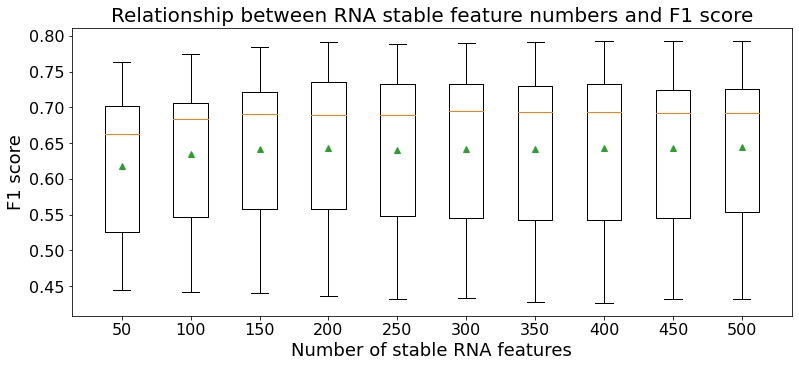

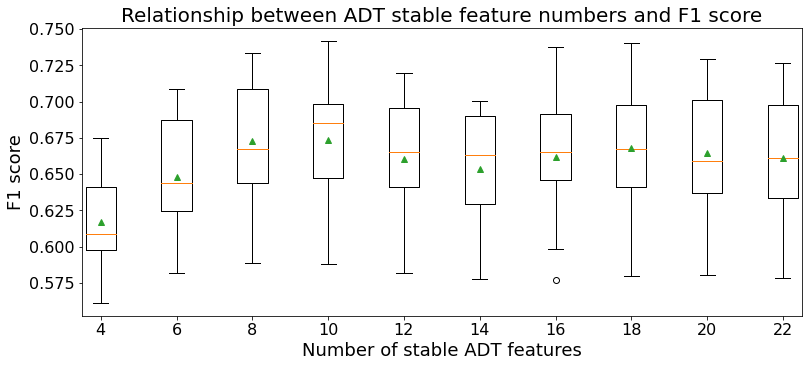

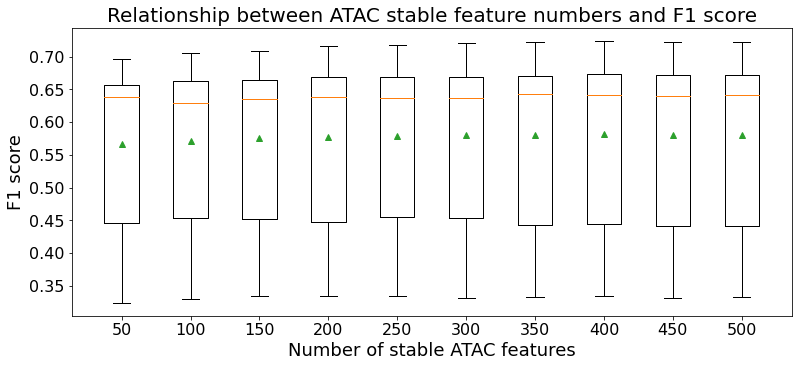

In [66]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
 
 

fig = plt.figure(figsize =(10, 4))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
a = np.transpose(f1_RNA)
# Creating plot
bp = ax.boxplot(a, positions=[50,100,150,200,250,300,350,400,450,500], widths=25, showmeans=True)
 
ax.tick_params(axis='x', labelsize=16) 
ax.tick_params(axis='y', labelsize=16) 
# Set labels and title
ax.set_xlabel('Number of stable RNA features', fontsize=18)
ax.set_ylabel('F1 score', fontsize=18)
ax.set_title('Relationship between RNA stable feature numbers and F1 score', fontsize=20)
# show plot
# Adjust the layout to include titles and axis labels
#plt.tight_layout()
plt.savefig('/ihome/wchen/hah112/CPDD_code/evaluate_stable_feature_number/RNA.png', bbox_inches='tight', facecolor='w', dpi=300)  # Set dpi to 300 for high resolution
plt.show()

 



fig = plt.figure(figsize =(10, 4))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
a = np.transpose(f1_ADT)
# Creating plot
bp = ax.boxplot(a, positions=[4,6,8,10, 12,14,16,18,20,22], widths=0.8, showmeans=True)
 
ax.tick_params(axis='x', labelsize=16) 
ax.tick_params(axis='y', labelsize=16) 
# Set labels and title
ax.set_xlabel('Number of stable ADT features', fontsize=18)
ax.set_ylabel('F1 score', fontsize=18)
ax.set_title('Relationship between ADT stable feature numbers and F1 score', fontsize=20)
# show plot
# Adjust the layout to include titles and axis labels
#plt.tight_layout()
plt.savefig('/ihome/wchen/hah112/CPDD_code/evaluate_stable_feature_number/ADT.png', bbox_inches='tight', facecolor='w', dpi=300)  # Set dpi to 300 for high resolution
plt.show()


fig = plt.figure(figsize =(10, 4))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
a = np.transpose(f1_ATAC)
# Creating plot
bp = ax.boxplot(a, positions=[50,100,150,200,250,300,350,400,450,500], widths=25, showmeans=True)
 
ax.tick_params(axis='x', labelsize=16) 
ax.tick_params(axis='y', labelsize=16) 
# Set labels and title
ax.set_xlabel('Number of stable ATAC features', fontsize=18)
ax.set_ylabel('F1 score', fontsize=18)
ax.set_title('Relationship between ATAC stable feature numbers and F1 score', fontsize=20)
# show plot
#plt.tight_layout()
# Adjust the layout to include titles and axis labels
plt.savefig('/ihome/wchen/hah112/CPDD_code/evaluate_stable_feature_number/ATAC.png', bbox_inches='tight', facecolor='w', dpi=300)  # Set dpi to 300 for high resolution
plt.show()

In [23]:
data.shape

AttributeError: 'list' object has no attribute 'shape'